In [1]:
from deeprxn.data import load_from_csv, construct_loader, Standardizer
from deeprxn.train import train, load_model, predict
from deeprxn.featurizer import make_featurizer
from deeprxn.utils import set_seed
from deeprxn.model import GNN
import numpy as np
import torch
from rdkit import Chem
import torch
import torch_geometric as tg
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
import pandas as pd
import os
from deeprxn.featurizer import make_featurizer
from rdkit.Chem.rdchem import Atom, Bond, HybridizationType, BondType
import numpy as np
from typing import Callable, Tuple, Union
from numpy.typing import ArrayLike
import torch_geometric.utils as tg_utils
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch_geometric.utils import to_networkx, subgraph
from deeprxn.data import AtomOriginType

In [9]:
from omegaconf import DictConfig, OmegaConf
import hydra
from hydra import initialize, compose
from hydra.core.config_store import ConfigStore

with initialize(version_base=None, config_path="./conf"):
    cfg = compose(config_name="config")
    OmegaConf.set_struct(cfg, False)
    #print(OmegaConf.to_yaml(cfg))

set_seed(cfg.seed)

### Features

In [10]:
cfg.features.atom_featurizer = "atom_rdkit_organic"
cfg.features.bond_featurizer = "bond_rdkit_base"
atom_featurizer = make_featurizer(cfg.features.atom_featurizer)
bond_featurizer = make_featurizer(cfg.features.bond_featurizer)

### Data

In [11]:
cfg.data.name = "barriers_e2"
smiles, labels = load_from_csv(cfg.data.name, "train")
print(f"Loaded {len(smiles)} training samples")

cfg.num_workers = 0
cfg.transformation.representation = "fully_connected" # connected_pair, CGR, connected_pair_only_dummy, fully_connected
cfg.transformation.connection_direction = "bidirectional" # bidirectional, reactants_to_products, products_to_reactants
cfg.transformation.dummy_node = "reactant_product" # reactant_product, reactant, product
cfg.transformation.dummy_connection_direction = "to_dummy" # bidirectional, to_dummy, from_dummy

train_loader = construct_loader(
    smiles, 
    labels, 
    atom_featurizer, 
    bond_featurizer, 
    cfg.num_workers, 
    shuffle=True, 
    mode='rxn', 
    representation=cfg.transformation.representation, 
    connection_direction=cfg.transformation.connection_direction,
    dummy_node=cfg.transformation.dummy_node,
    dummy_connection_direction=cfg.transformation.dummy_connection_direction
)

Loaded 800 training samples


### Model

In [12]:
# Adjust model settings
cfg.model.num_node_features = train_loader.dataset.num_node_features
cfg.model.num_edge_features = train_loader.dataset.num_edge_features
cfg.model.depth = 3
cfg.model.hidden_size = 300
cfg.model.dropout = 0.02
cfg.model.pool_type = "products"
cfg.model.separate_nn = False
cfg.model.pool_real_only = False

model = GNN(**cfg.model)
print(model)

GNN(
  (edge_init): Linear(in_features=55, out_features=300, bias=True)
  (convs): ModuleList(
    (0-2): 3 x DMPNNConv()
  )
  (edge_to_node): Linear(in_features=344, out_features=300, bias=True)
  (ffn): Sequential(
    (0): Dropout(p=0.02, inplace=False)
    (1): Linear(in_features=300, out_features=300, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.02, inplace=False)
    (4): Linear(in_features=300, out_features=1, bias=True)
  )
)


### An example

In [13]:
data = next(iter(train_loader))
sample = data[0]

print(f"Node features [num_atoms, num_atom_feat]: {sample.x.shape}")
print(f"Edge index [2, num_bond]: {sample.edge_index.shape}")
print(f"Edge attributes [num_bond, num_bond_feat]: {sample.edge_attr.shape}")
print(f"Target label: {sample.y.shape}")
print(f"Atom origin type: {sample.atom_origin_type.shape}")
print(f"Is real bond: {sample.is_real_bond.shape}, real bonds: {sample.is_real_bond.sum()}, fake bonds: {(~sample.is_real_bond).sum()}")
print(f"Connection direction: {sample.connection_direction}")

Node features [num_atoms, num_atom_feat]: torch.Size([27, 44])
Edge index [2, num_bond]: torch.Size([2, 676])
Edge attributes [num_bond, num_bond_feat]: torch.Size([676, 11])
Target label: torch.Size([1])
Atom origin type: torch.Size([27])
Is real bond: torch.Size([676]), real bonds: 42, fake bonds: 634
Connection direction: bidirectional


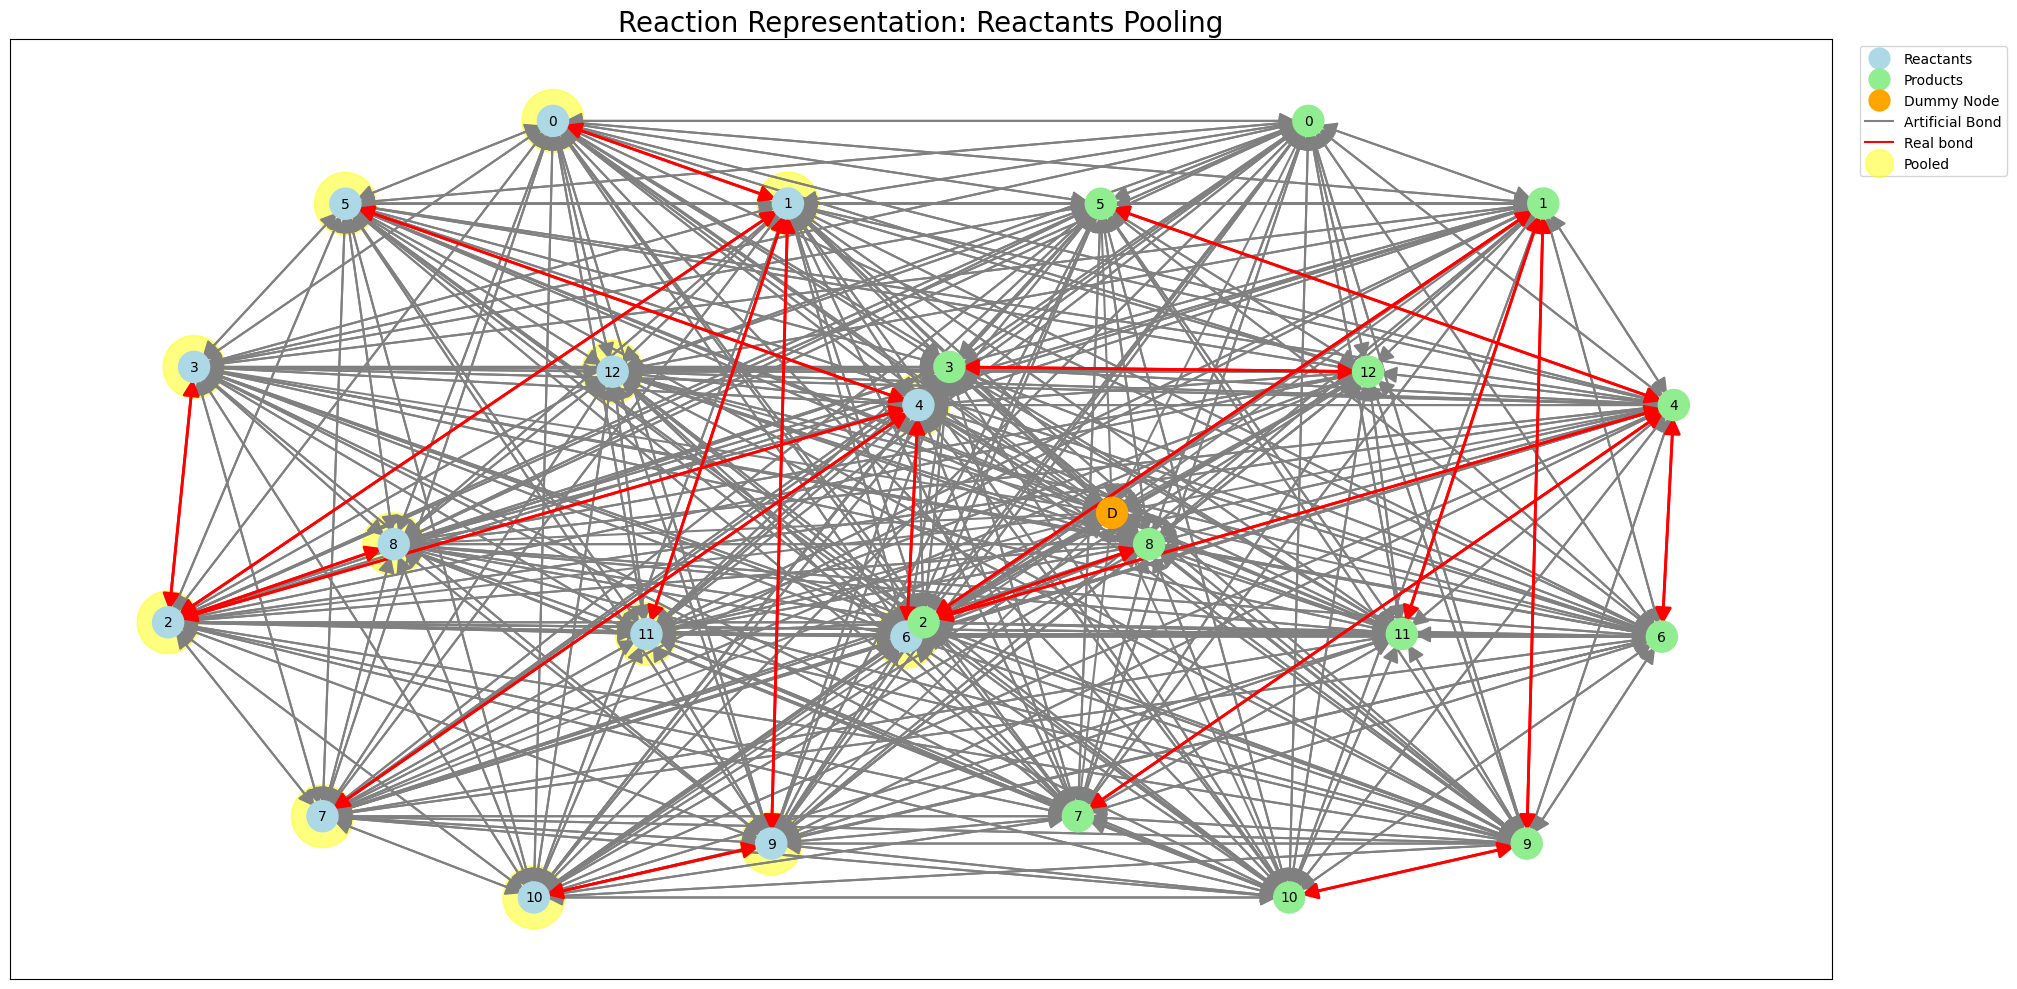

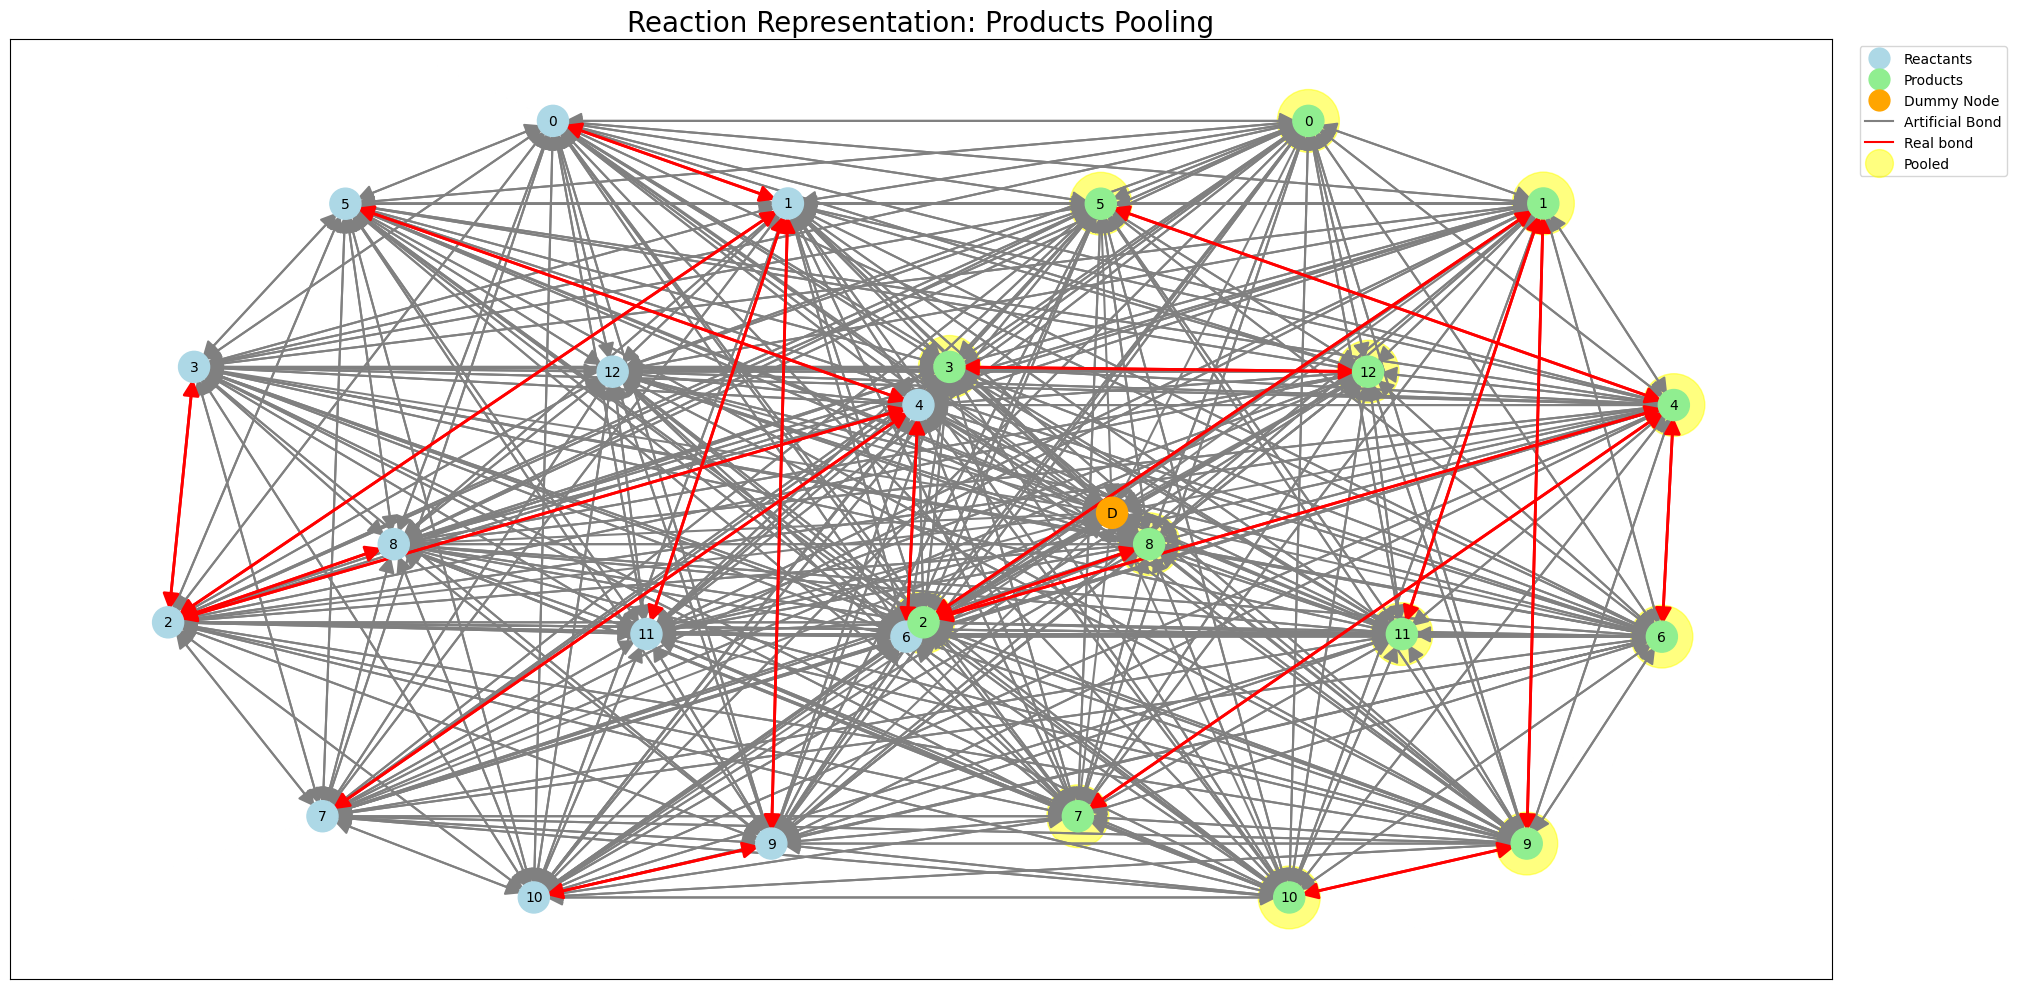

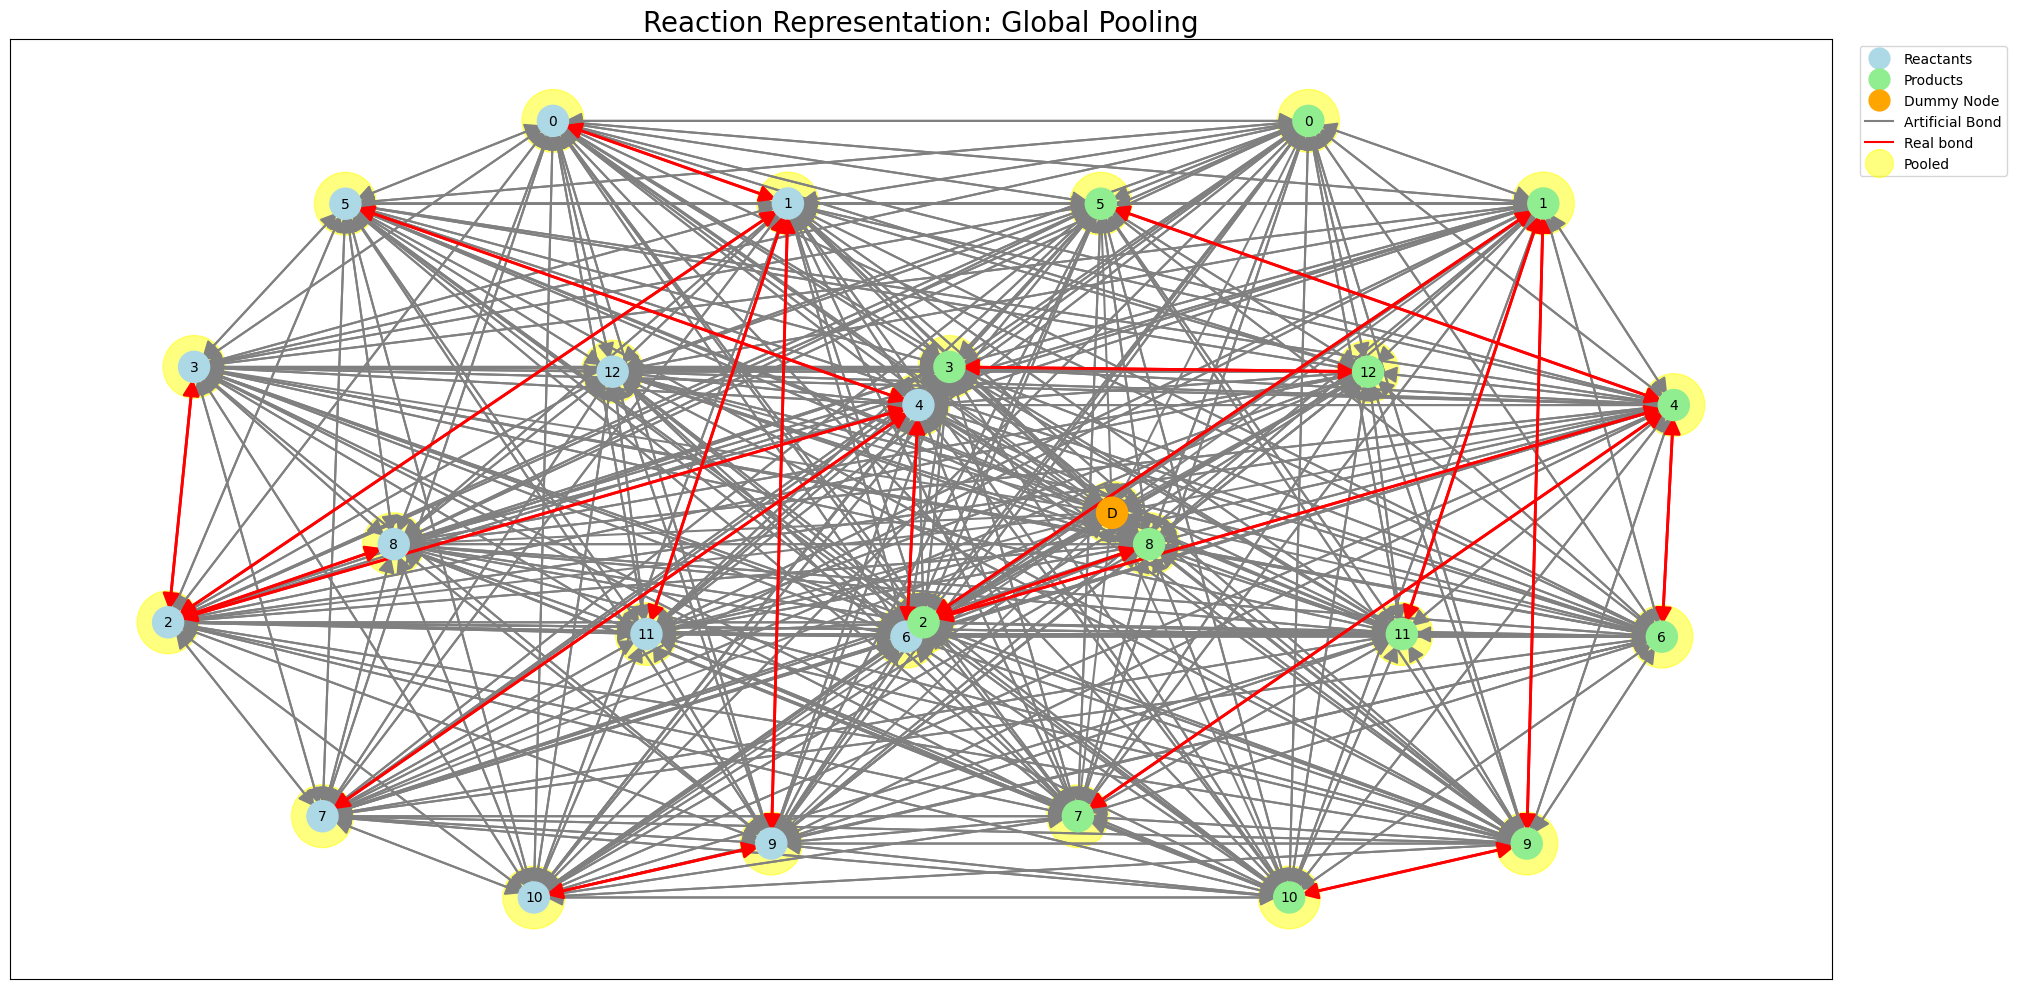

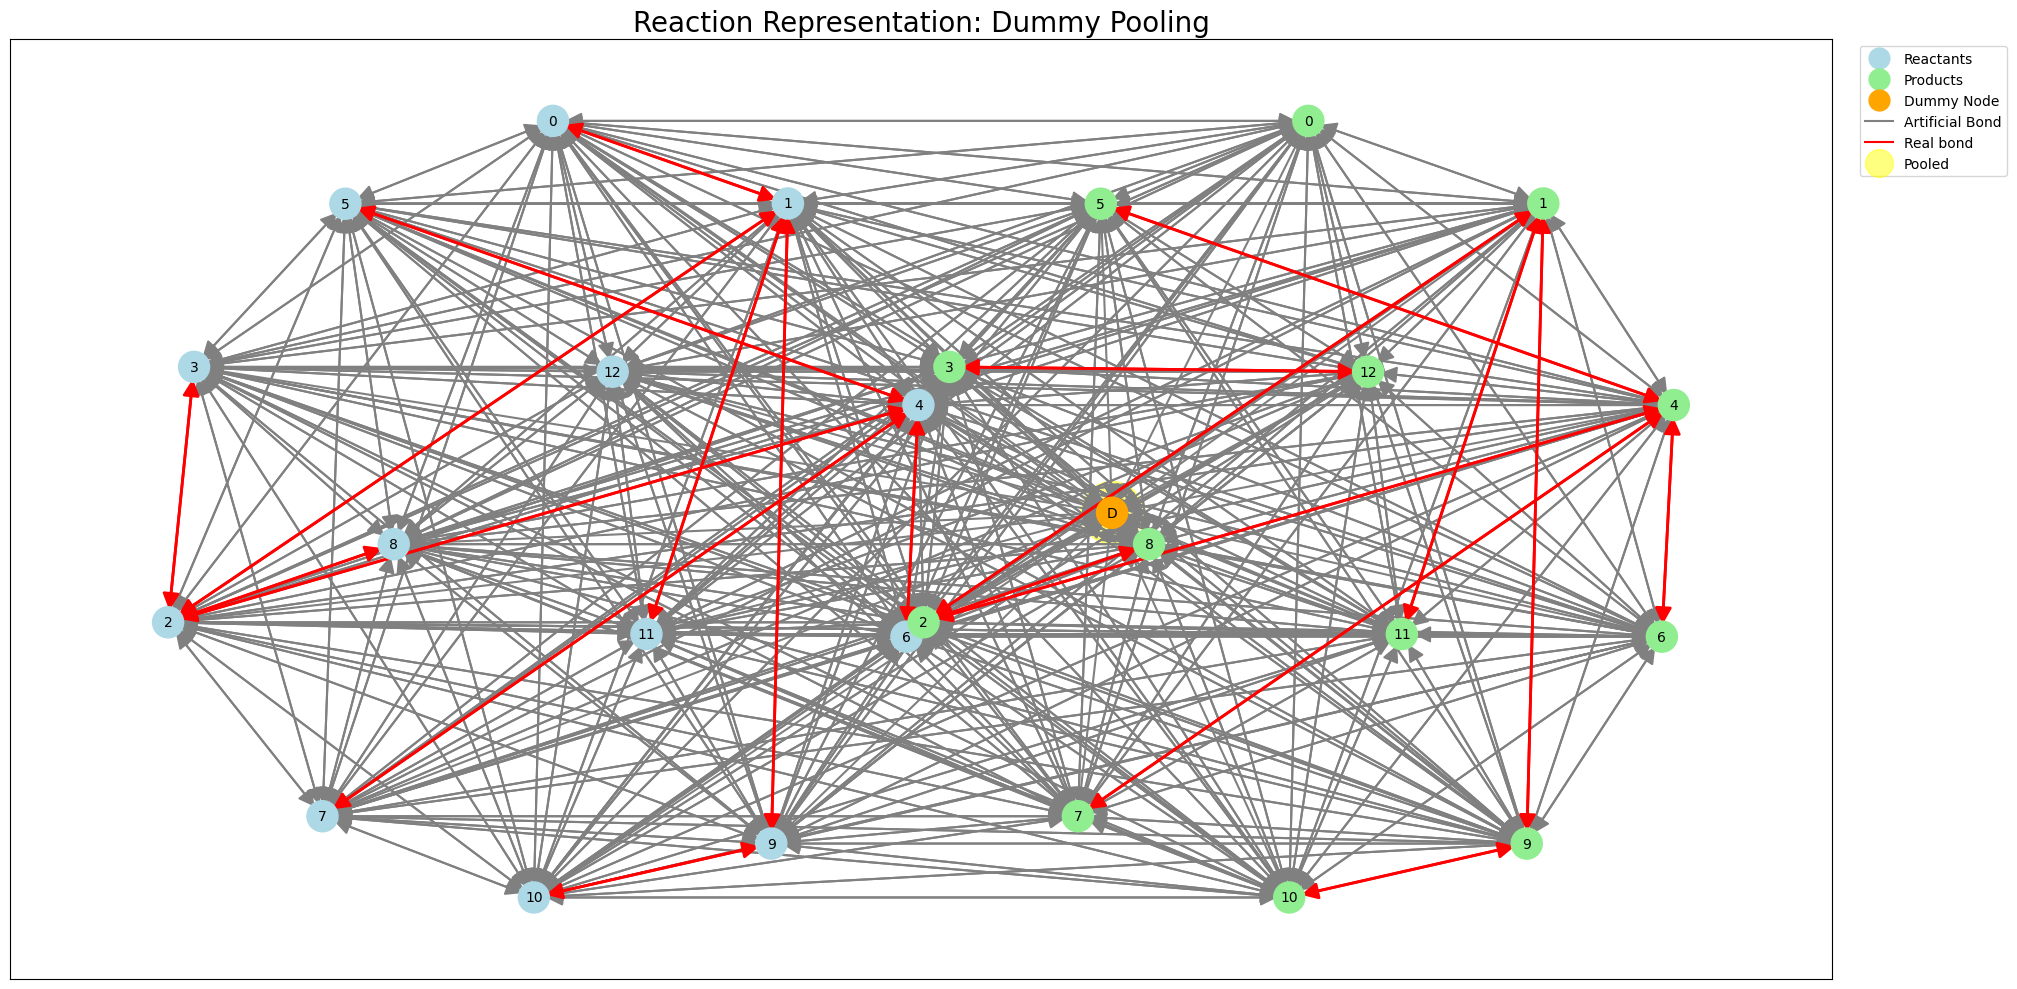

In [14]:
def split_data(data):
    # Split data into reactants and products
    reactant_mask = data.atom_origin_type == AtomOriginType.REACTANT
    product_mask = data.atom_origin_type == AtomOriginType.PRODUCT
    
    reactants = data.clone()
    reactants.x = data.x[reactant_mask]
    reactants.edge_index, reactants.edge_attr = subgraph(reactant_mask, data.edge_index, data.edge_attr, relabel_nodes=True)
    
    products = data.clone()
    products.x = data.x[product_mask]
    products.edge_index, products.edge_attr = subgraph(product_mask, data.edge_index, data.edge_attr, relabel_nodes=True)
    
    return reactants, products

def create_graph(data):
    G = nx.DiGraph()
    G.add_nodes_from(range(data.x.size(0)))
    edge_index = data.edge_index.t().tolist()
    G.add_edges_from(edge_index)
    return G

def draw_background_highlights(G, pos, ax, node_highlight, is_dummy):
    for node, (x, y) in pos.items():
        if node_highlight[node]:
            circle = patches.Circle((x, y), radius=0.08, fill=True, color='yellow', alpha=0.5)
            ax.add_patch(circle)

def position_nodes(G_reactants, G_products, G_full, is_dummy):
    pos_reactants = nx.spring_layout(G_reactants, seed=42)
    max_x = max(pos[0] for pos in pos_reactants.values())
    shift = max_x + 1.0
    pos_products = {node: (x + shift, y) for node, (x, y) in pos_reactants.items()}
    pos_combined = pos_reactants.copy()
    pos_combined.update({node + len(G_reactants): pos for node, pos in pos_products.items()})
    
    # Position dummy node at the center
    if any(is_dummy):
        dummy_node = next(node for node in G_full.nodes() if is_dummy[node])
        dummy_x = (max_x + shift) / 2
        dummy_y = 0
        pos_combined[dummy_node] = (dummy_x, dummy_y)
    
    return pos_combined

def determine_highlighting(data, pool_type):
    node_highlight = []
    is_dummy = []

    for atom_type in data.atom_origin_type:
        is_dummy.append(atom_type == AtomOriginType.DUMMY)

        if pool_type == "global":
            node_highlight.append(True)
        elif pool_type == "reactants":
            node_highlight.append(atom_type == AtomOriginType.REACTANT)
        elif pool_type == "products":
            node_highlight.append(atom_type == AtomOriginType.PRODUCT)
        elif pool_type == "dummy":
            node_highlight.append(atom_type == AtomOriginType.DUMMY)

    return node_highlight, is_dummy

def visualize_graphs(data, pool_type="global"):
    # Split data into reactants and products
    reactants, products = split_data(data)

    # Create graphs
    G_reactants = create_graph(reactants)
    G_products = create_graph(products)
    G_full = create_graph(data)

    # Determine highlighting and dummy nodes
    node_highlight, is_dummy = determine_highlighting(data, pool_type)

    # Position nodes
    pos_combined = position_nodes(G_reactants, G_products, G_full, is_dummy)

    # Create a single figure
    fig, ax = plt.subplots(figsize=(20, 10))

    # Draw background highlights
    draw_background_highlights(G_full, pos_combined, ax, node_highlight, is_dummy)

    # Prepare node color map
    node_color_map = []
    for atom_type in data.atom_origin_type:
        if atom_type == AtomOriginType.DUMMY:
            node_color_map.append('orange')  # Color for dummy node
        elif atom_type == AtomOriginType.REACTANT:
            node_color_map.append('lightblue')  # Color for reactants
        else:
            node_color_map.append('lightgreen')  # Color for products

    # Draw the combined graph
    nx.draw_networkx_nodes(G_full, pos_combined, ax=ax, node_color=node_color_map, node_size=500)

    # Create labels for reactants and products
    labels = {}
    reactant_count = 0
    product_count = 0
    for i, atom_type in enumerate(data.atom_origin_type):
        if atom_type == AtomOriginType.DUMMY:
            labels[i] = 'D'  # Label for dummy node
        elif atom_type == AtomOriginType.REACTANT:
            labels[i] = str(reactant_count)
            reactant_count += 1
        else:
            labels[i] = str(product_count)
            product_count += 1

    nx.draw_networkx_labels(G_full, pos_combined, labels, ax=ax, font_size=10)

    # Draw edges (unchanged)
    non_real_edges = [(u, v) for (u, v), real in zip(data.edge_index.t().tolist(), data.is_real_bond) if not real]
    nx.draw_networkx_edges(G_full, pos_combined, ax=ax, edgelist=non_real_edges, edge_color='gray', arrows=True, arrowsize=25, width=1.5)

    real_edges = [(u, v) for (u, v), real in zip(data.edge_index.t().tolist(), data.is_real_bond) if real]
    nx.draw_networkx_edges(G_full, pos_combined, ax=ax, edgelist=real_edges, edge_color='r', arrows=True, arrowsize=25, width=2)

    # Add legend (unchanged)
    ax.plot([], [], 'lightblue', marker='o', markersize=15, linestyle='', label='Reactants')
    ax.plot([], [], 'lightgreen', marker='o', markersize=15, linestyle='', label='Products')
    ax.plot([], [], 'orange', marker='o', markersize=15, linestyle='', label='Dummy Node')
    ax.plot([], [], 'gray', label='Artificial Bond')
    ax.plot([], [], 'r-', label='Real bond')
    ax.plot([], [], color='yellow', marker='o', markersize=20, alpha=0.5, linestyle='', label='Pooled')
    
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

    ax.set_title(f"Reaction Representation: {pool_type.capitalize()} Pooling", fontsize=20)
    plt.tight_layout()
    plt.show()

# Example usage
visualize_graphs(sample, pool_type="reactants")
visualize_graphs(sample, pool_type="products")
visualize_graphs(sample, pool_type="global")
visualize_graphs(sample, pool_type="dummy")